                                     Plant_Disease   Count
0                                 Cherry - healthy   854.0
1                          Cherry - Powdery_mildew  1052.0
21                                 Grape - healthy   423.0
23                               Grape - Black_rot  1180.0
24      Grape - Leaf_blight_(Isariopsis_Leaf_Spot)  1076.0
25                    Grape - Esca_(Black_Measles)  1383.0
42                               Soybean - healthy  5090.0
63                                Tomato - healthy  1591.0
68                            Tomato - Late_blight  1909.0
69   Tomato - Spider_mites Two-spotted_spider_mite  1676.0
70          Tomato - Tomato_Yellow_Leaf_Curl_Virus  5357.0
71                         Tomato - Bacterial_spot  2127.0
72                     Tomato - Septoria_leaf_spot  1771.0
73                    Tomato - Tomato_mosaic_virus   373.0
74                              Tomato - Leaf_Mold   952.0
75                           Tomato - Early_blight  1000

/tmp/ipykernel_43403/1379078437.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fused, x="Plant_Disease", y="Count", palette="Set1")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


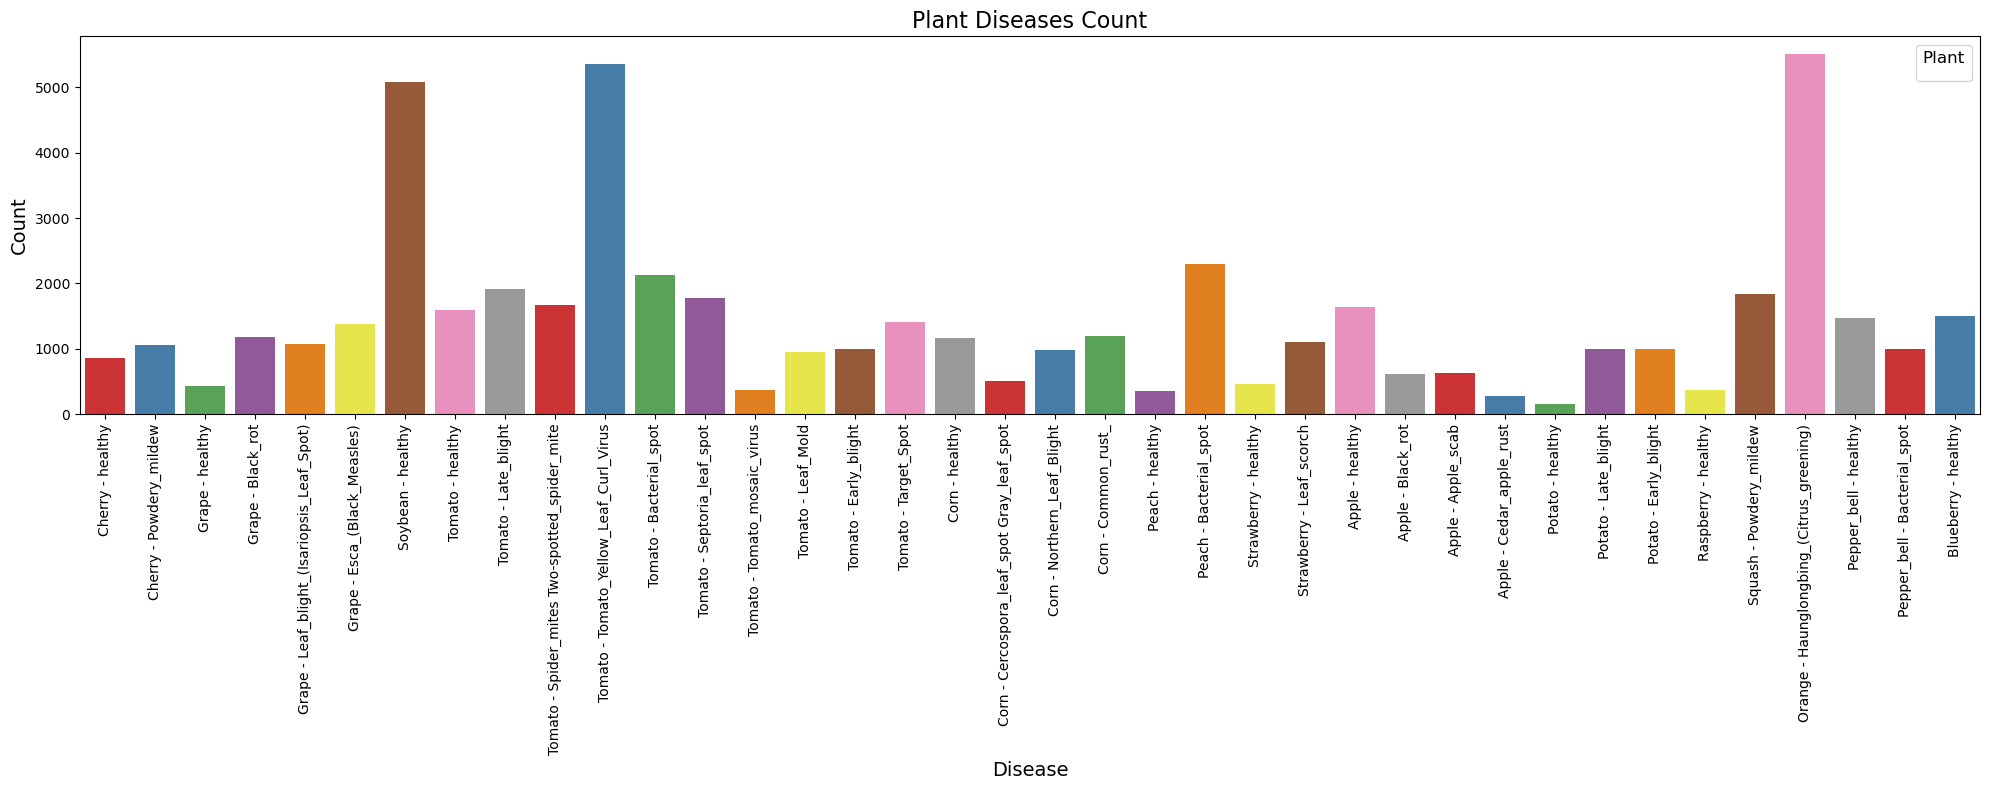

In [68]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns


df = pd.read_json("data/classes.json")

# Reset index so Disease is a column
df = df.reset_index().rename(columns={"index": "Disease"})

# Melt to long format (Plant, Disease, Count)
df_long = df.melt(id_vars="Disease", var_name="Plant", value_name="Count")

# Drop NaNs
df_long = df_long.dropna(subset=["Count"])

# Optional: reorder columns
df_long = df_long[["Plant", "Disease", "Count"]]
# Create a new column combining Plant and Disease
df_long["Plant_Disease"] = df_long["Plant"] + " - " + df_long["Disease"]

# Optional: drop the original Plant and Disease columns
df_fused = df_long[["Plant_Disease", "Count"]]

print(df_fused)

# Single grouped bar plot
plt.figure(figsize=(20,8))  # width=14, height=8 (adjust as needed)
sns.barplot(data=df_fused, x="Plant_Disease", y="Count", palette="Set1")
plt.title("Plant Diseases Count", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Disease", fontsize=14)
plt.xticks(rotation=90)  # rotate labels vertically
plt.legend(title="Plant", fontsize=12, title_fontsize=12)
plt.tight_layout()  # fit everything nicely
plt.show()

